In [ ]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
sys.path.append("../")

In [ ]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter_train_val_test

In [5]:
from DataSets import UNetDatasetFromFolders

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
DATA_DIR_IH = "/data/uob/"

data_dir = DATA_DIR_DEEPTHOUGHT

In [8]:
data_dir = DATA_DIR_IH

In [9]:
model_name = os.path.join(data_dir, "trained_dt","trained_cUNet_pytorch_regression_complete_dataset_50epochs_coeff_mask0.75_validation.pkl")

In [10]:
model_inference = cUNet(out_size=1)

In [13]:
model_inference.load_state_dict(torch.load(model_name));

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
root_folder = os.path.join(data_dir, "dataset")

In [16]:
composed = transforms.Compose([Cut(), Rescale(.25), ChannelsFirst(), ToTensor()])

In [17]:
complete_dataset = UNetDatasetFromFolders(root_folder, transform=composed)

In [18]:
batch_size=16

In [19]:
data_loaders, data_lengths = splitter_train_val_test(complete_dataset,
                                                    validation_split=0.2,
                                                    test_split=0.2,
                                                    batch=batch_size,
                                                    workers=4)

In [20]:
data_lengths

{'train': 5717, 'val': 1429, 'test': 1786}

In [21]:
model_inference.eval()
model_inference.to(device);

batch 1


1: true_dist: 3, pred_dist: [3.0249662]


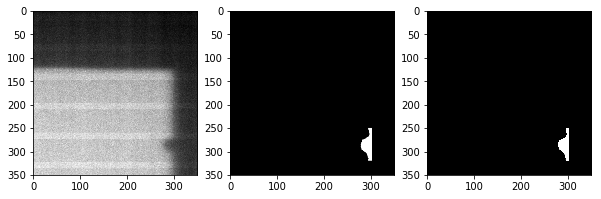

2: true_dist: 20, pred_dist: [20.12613]


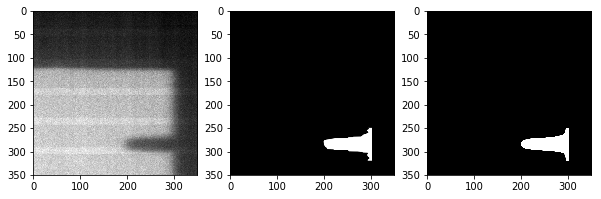

3: true_dist: 4, pred_dist: [3.8664987]


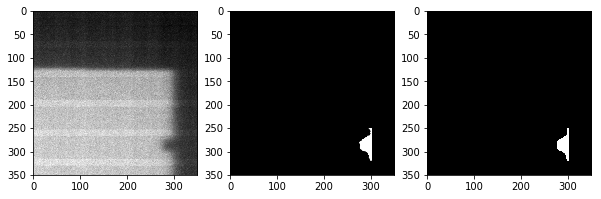

4: true_dist: 30, pred_dist: [30.198845]


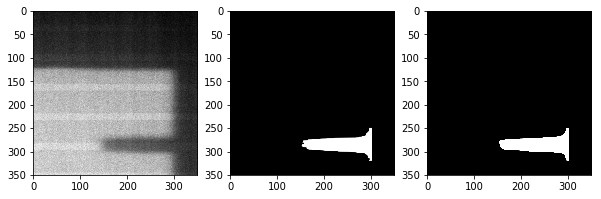

5: true_dist: 3, pred_dist: [3.0187066]


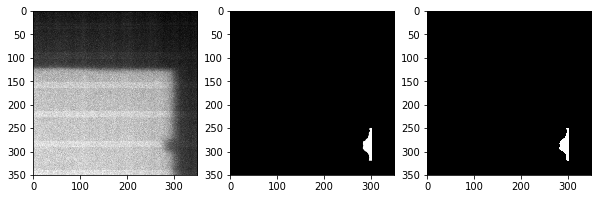

6: true_dist: 4, pred_dist: [4.0546756]


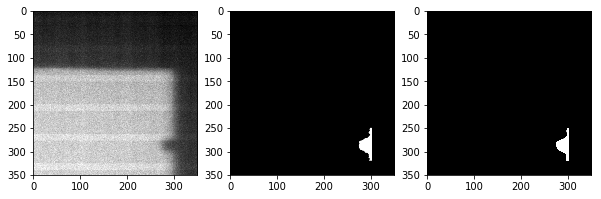

7: true_dist: 35, pred_dist: [35.39844]


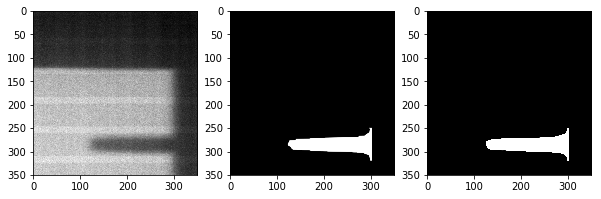

8: true_dist: 4, pred_dist: [4.050297]


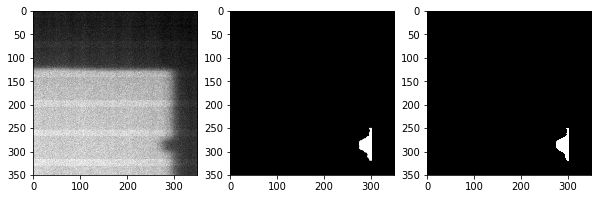

9: true_dist: 2, pred_dist: [1.9694687]


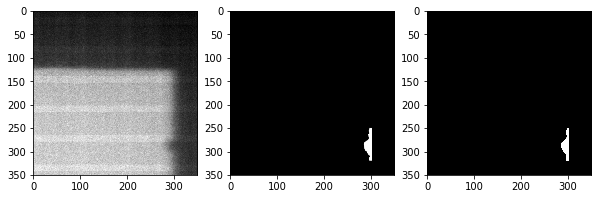

10: true_dist: 30, pred_dist: [30.22239]


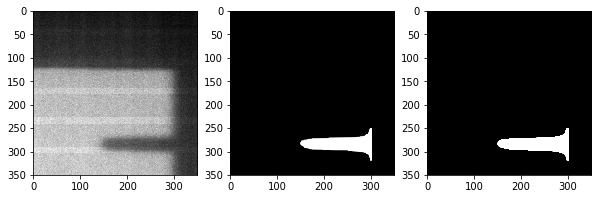

11: true_dist: 15, pred_dist: [15.098313]


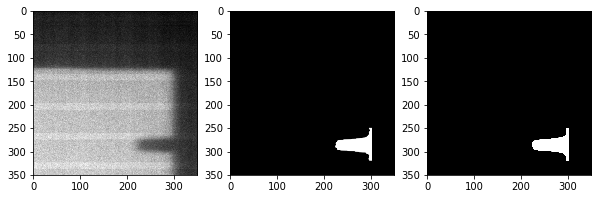

12: true_dist: 2, pred_dist: [1.9846592]


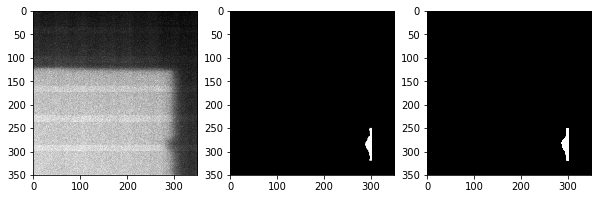

13: true_dist: 30, pred_dist: [30.33604]


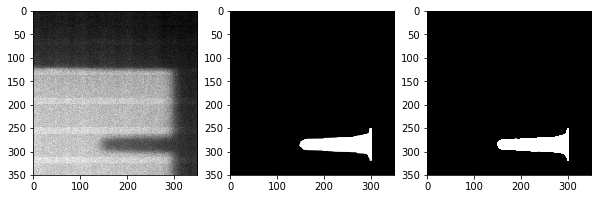

14: true_dist: 3, pred_dist: [2.9805713]


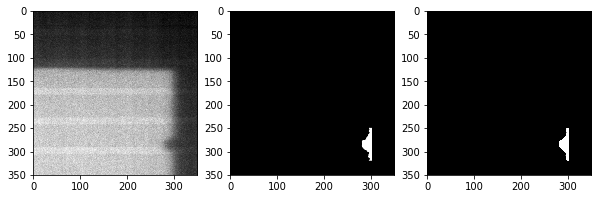

15: true_dist: 3, pred_dist: [3.056409]


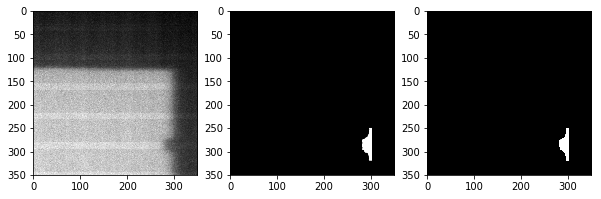

16: true_dist: 1, pred_dist: [0.8777504]


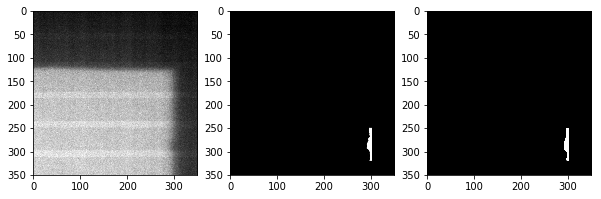


batch 2


1: true_dist: 25, pred_dist: [25.076727]


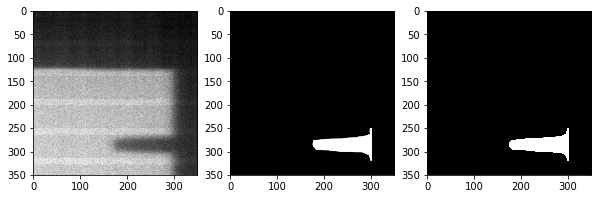

2: true_dist: 30, pred_dist: [30.228329]


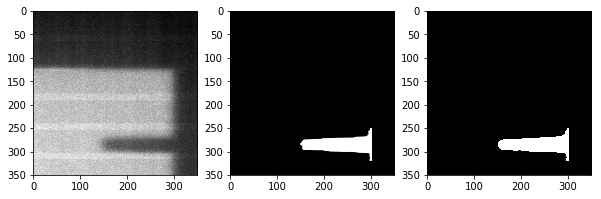

3: true_dist: 35, pred_dist: [35.349846]


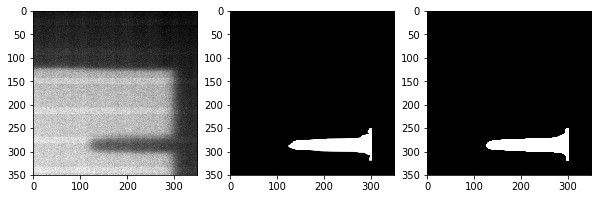

4: true_dist: 2, pred_dist: [2.008971]


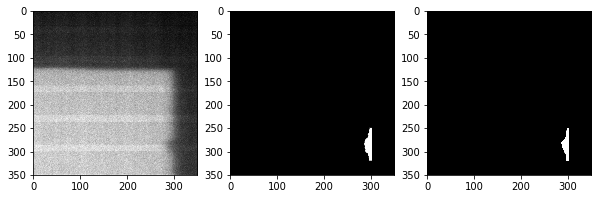

5: true_dist: 3, pred_dist: [3.0299337]


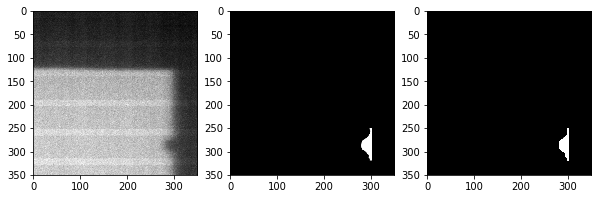

6: true_dist: 20, pred_dist: [20.102093]


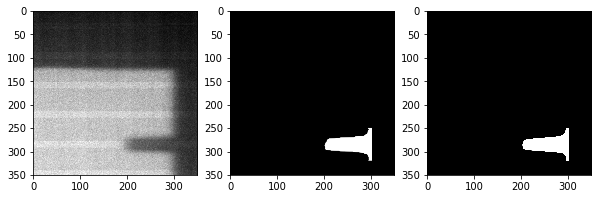

7: true_dist: 20, pred_dist: [20.14597]


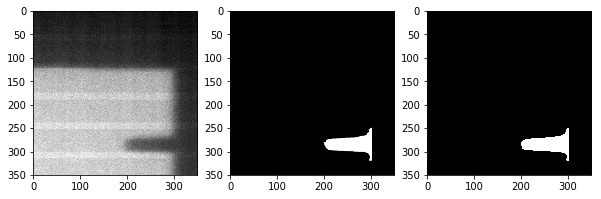

8: true_dist: 10, pred_dist: [9.879572]


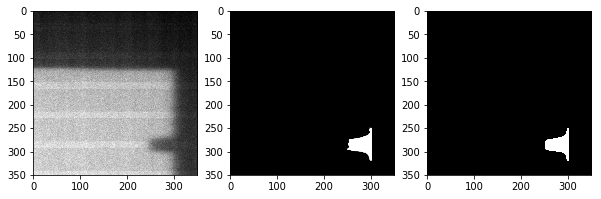

9: true_dist: 10, pred_dist: [10.055937]


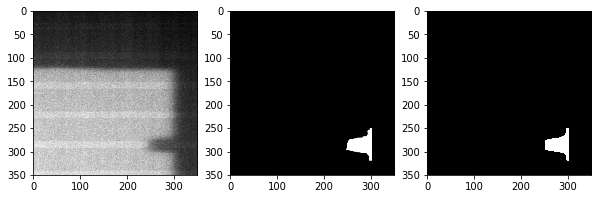

10: true_dist: 3, pred_dist: [2.997647]


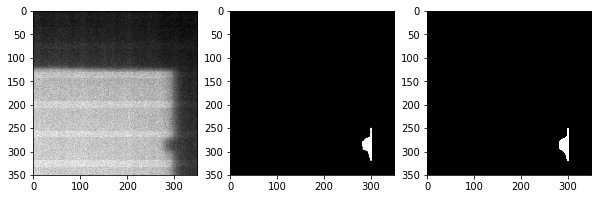

11: true_dist: 10, pred_dist: [10.015405]


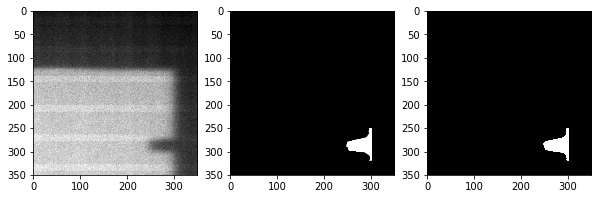

12: true_dist: 2, pred_dist: [1.8437606]


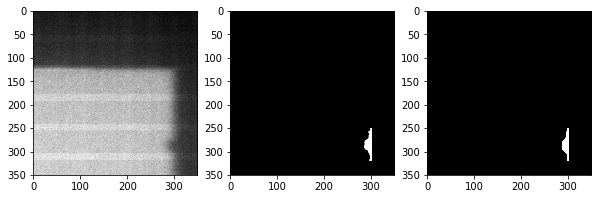

13: true_dist: 25, pred_dist: [25.066462]


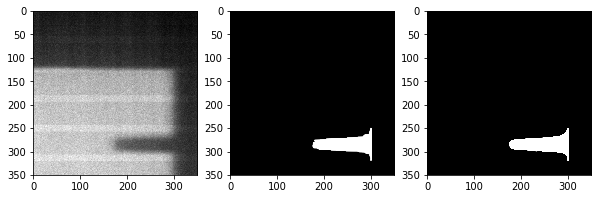

14: true_dist: 20, pred_dist: [20.071909]


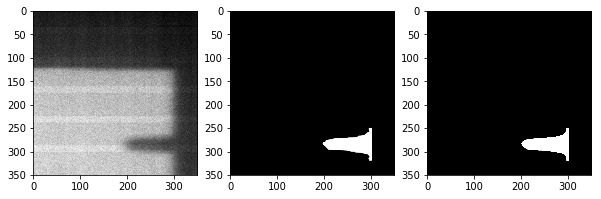

15: true_dist: 35, pred_dist: [35.403587]


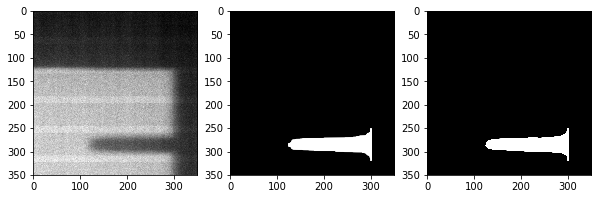

16: true_dist: 15, pred_dist: [15.040404]


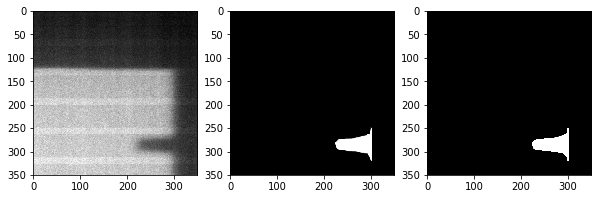

In [30]:
for i, batch in tqdm(enumerate(data_loaders['test']),desc='Epochs'):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_dist, pr_msk, pr_dist) in tqdm(enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())), 
                                                            total=data_lengths['test']//batch_size,
                                                            desc = 'Mini Batch'):
    
        true_dist = tr_dist
        pred_dist = pr_dist
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [31]:
batch_size=16

In [22]:
y_true = []
y_pred = []

for i, batch in tqdm(enumerate(data_loaders['test']), total = data_lengths['test']//batch_size, desc = "Mini Batch"):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_dists.cpu().detach().numpy())):
        true_dist = tr_dist
        pred_dist = pr_dist
        y_true.append(true_dist)
        y_pred.append(pred_dist)




In [23]:
y_pred = np.asarray(y_pred).ravel()
y_true = np.asarray(y_true)

print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 0.02321060908410414


In [24]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [25]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [26]:
idx_1, mse_1 = idx_mse(1)
idx_2, mse_2 = idx_mse(2)
idx_3, mse_3 = idx_mse(3)
idx_4, mse_4 = idx_mse(4)
idx_10, mse_10 = idx_mse(10)
idx_15, mse_15 = idx_mse(15)
idx_20, mse_20 = idx_mse(20)
idx_25, mse_25 = idx_mse(25)
idx_30, mse_30 = idx_mse(30)
idx_35, mse_35 = idx_mse(35)

1 0.0023211389200707764
2 0.002337774933980554
3 0.00226284105681936
4 0.0021868820134966927
10 0.0035078534932875952
15 0.00856645115426444
20 0.016398969746275242
25 0.031539766906924685
30 0.05426720336041219
35 0.10338871247089759


In [27]:
distances = [1,2,3,4,10,15,20,25,30,35]

In [28]:
errors = [idx_mse(i)[1] for i in distances]

1 0.0023211389200707764
2 0.002337774933980554
3 0.00226284105681936
4 0.0021868820134966927
10 0.0035078534932875952
15 0.00856645115426444
20 0.016398969746275242
25 0.031539766906924685
30 0.05426720336041219
35 0.10338871247089759


(0, 0.5)

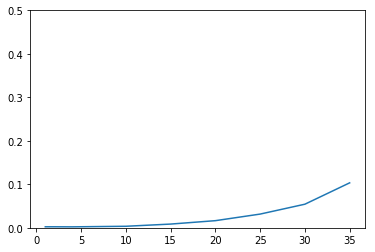

In [31]:
plt.plot(distances, errors)
plt.ylim((0,0.5))

In [32]:
np.savez_compressed("Predicted_alldat_trained_alldata.npz",
                   true = y_true, pred = y_pred)